## Лабораторная работа

**Студенты:** Коршунова Анастасия, Деркач Алёна

In [65]:
# pip install imgaug
# pip install torchvision

## **1. Подготовка данных**

В данной лабораторной работе мы будем использовать следующий датасет: https://www.kaggle.com/datasets/ryanbadai/clothes-dataset
В данном датасете `15` папок по `500` фотографий различной одежды:
- Blazer
- Long Pants
- Shorts
- Dresses
- Hoodie
- Jacket
- Jaket_Denim
- Jacket_Sports
- Jeans
- T-shirt
- Kemeja
- Coat
- Polo
- Skirt
- Sweater

Разрешение фотографий `720х1280`. Формат `jpg`.

Для задачи классификации изображений хорошо подходят модели из `torchvision.models`, например `ResNet50`.

`ResNet50` — это популярная модель, которая хорошо работает на многих задачах. Она принимает изображения размером 224x224, поэтому нам нужно будет изменить размер изображений.

Перед обучением модели выполним следующее:

- **Изменение размера изображений**
- **Нормализация** 
- **Аугментации**

In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

import imgaug.augmenters as iaa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import os

#### **Шаг 1: Загрузка данных**

In [202]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

dataset = ImageFolder(root="Clothes_Dataset", transform=data_transform)

In [203]:
print(f'''
Общее количество изображений: {len(dataset)}
Количество классов: {len(dataset.classes)}
Пример метки и изображения: {dataset[0][1]}, {dataset[0][0].shape}''')


Общее количество изображений: 7500
Количество классов: 15
Пример метки и изображения: 0, torch.Size([3, 224, 224])


#### **Шаг 2: Разделение данных**

In [204]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [205]:
print(f'''
Тренировочная выборка: {len(train_dataset)} изображений
Валидационная выборка: {len(val_dataset)} изображений
Тестовая выборка: {len(test_dataset)} изображений''')


Тренировочная выборка: 5250 изображений
Валидационная выборка: 1125 изображений
Тестовая выборка: 1125 изображений


#### **Шаг 3: Аугментации для тренировочной выборки**

Мы добавим следующие аугментации:
- Случайные повороты (от -15 до 15 градусов).
- Случайные обрезки (crop).
- Изменение яркости и контраста.
- Размытие (гауссово размытие).
- Добавление шума (гауссов шум).
- Отражение по горизонтали (с вероятностью 50%).
- Случайное изменение насыщенности.

In [ ]:
augmenter = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Fliplr(0.5)), # Отражение по горизонтали с вероятностью 50%
    iaa.Sometimes(0.5, iaa.Affine(
        rotate=(-30, 30), # Случайные повороты от -15 до 15 градусов
        scale=(0.8, 1.2) # Случайное масштабирование
    )),
    iaa.ChannelShuffle(0.35),
    iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.05))), # Случайные обрезки
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.0))), # Размытие
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.20 * 255))), # Гауссов шум
    iaa.Sometimes(0.5, iaa.MultiplyBrightness((0.8, 1.2))), # Изменение яркости
    iaa.Sometimes(0.5, iaa.LinearContrast((1, 2))), # Изменение контраста
    iaa.Sometimes(0.5, iaa.MultiplySaturation((0.8, 1.2))), # Изменение насыщенности
])

def apply_imgaug(image):
    image_np = np.array(image)  # Преобразуем изображение в numpy array
    augmented_image = augmenter(image=image_np)  # Применяем аугментации
    return Image.fromarray(augmented_image)  # Возвращаем изображение в формате PIL

train_transform = transforms.Compose([
    transforms.Lambda(apply_imgaug),  # Применяем аугментации
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

train_dataset.dataset.transform = train_transform

#### **Шаг 4: Создание DataLoader**

In [207]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### **Шаг 5: Сохранение данных**

In [208]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

#### **Проверка**

Теперь посмотрим какие изображения мы получили. Возьмём по одному изображению из каждого класса.

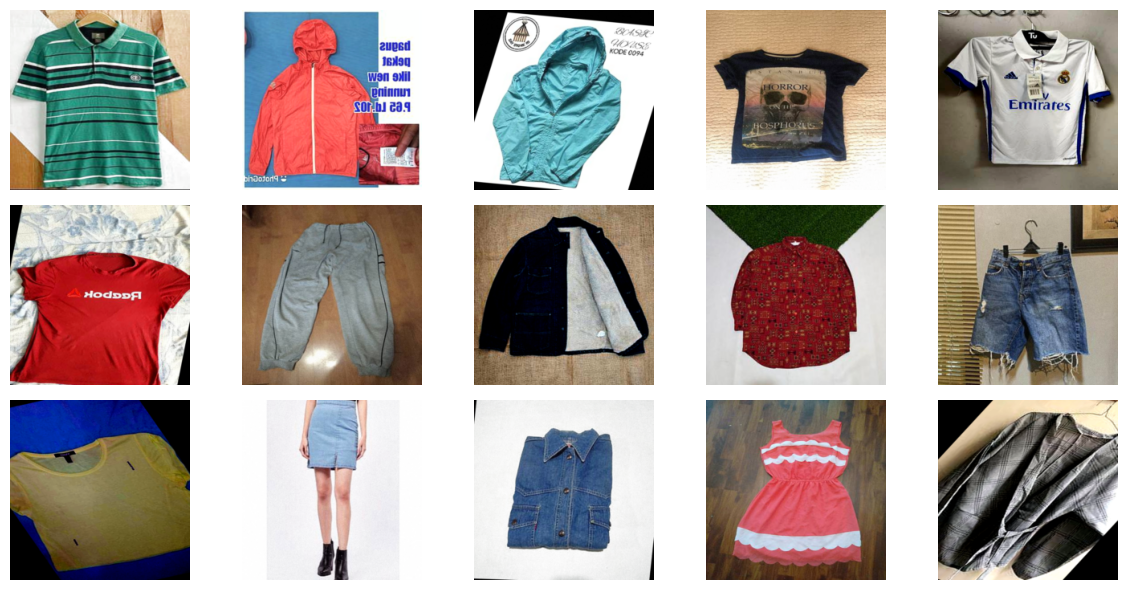

In [209]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.clone()
    for i in range(3):
        image[i] = image[i] * std[i] + mean[i]
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    return image

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = denormalize(images[i]) # Денормализуем изображение
        ax.imshow(image)
        ax.axis("off")
plt.tight_layout()
plt.show()

## **2. Выбор модели**

In [210]:
import torchvision.models as models
from torch import nn

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 15) # Замена последнего слоя на 15 классов
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for param in model.parameters():
    param.requires_grad = False  # Замораживаем все слои
for param in model.classifier.parameters():
    param.requires_grad = True  # Размораживаем последний слой

torch.save(model, "model.pth")

C:\Users\} { ome\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\} { ome\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **3. Настройка обучения**

Функция потерь и оптимизатор

In [211]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

CutMix

In [200]:
def cutmix_data(x, y, alpha=1.0):
    batch_size, _, height, width = x.size()
    indices = torch.randperm(batch_size)
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.random.beta(alpha, alpha)
    cut_ratio = np.sqrt(1 - lam)
    cut_width = int(width * cut_ratio)
    cut_height = int(height * cut_ratio)

    cx = np.random.randint(width)
    cy = np.random.randint(height)
    x1 = int(np.clip(cx - cut_width // 2, 0, width))
    y1 = int(np.clip(cy - cut_height // 2, 0, height))
    x2 = int(np.clip(cx + cut_width // 2, 0, width))
    y2 = int(np.clip(cy + cut_height // 2, 0, height))

    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = shuffled_x[:, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (width * height))
    mixed_y = y * lam + shuffled_y * (1 - lam)

    return mixed_x, mixed_y

In [169]:
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

In [ ]:
# TensorBoard
writer = SummaryWriter('runs/clothes_classification_experiment')
dummy_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(model, dummy_input)

# Gradient Clipping
max_grad_norm = 1.0

In [ ]:
# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

## **4. Обучение модели**

In [ ]:
for epoch in range(20):  # 20 эпох
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/20", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Преобразуем метки в one-hot encoded формат
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        # Применяем CutMix
        inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Преобразуем mixed метки обратно в индексы классов
        labels_indices = labels_mixed.argmax(dim=1)
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

        # Логируем пример изображения из батча (только на первой эпохе)
        if epoch == 0:
            img_grid = torchvision.utils.make_grid(inputs[:4].cpu())  # Берем первые 4 изображения из батча
            writer.add_image('Example Images', img_grid, epoch)

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    print(f"Epoch {epoch + 1}/20")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем writer
writer.close()

In [ ]:
# 6. Тестирование модели
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Метрики
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test Recall: {recall:.4f}")

# Сохранение метрик
with open('test_results.txt', 'w') as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")

# Confusion Matrix
class_names = ['Blazer', 'Long Pants', 'Shorts', 'Dresses', 'Hoodie', 'Jacket', 'Jaket_Denim', 'Jacket_Sports', 'Jeans', 'T-shirt', 'Kemeja', 'Coat', 'Polo', 'Skirt', 'Sweater']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Примеры изображений с предсказаниями
def visualize_predictions(model, test_loader, class_names, num_examples=5, save_dir='examples'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 10))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
        plt.savefig(os.path.join(save_dir, f'example_{i + 1}.png'))
    plt.show()

visualize_predictions(model, test_loader, class_names)

In [ ]:
# Цикл обучения
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения
    running_loss = 0.0
    running_accuracy = 0.0

    # Прогресс-бар для тренировочной выборки
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    for inputs, labels in train_loop:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Считаем метрики
        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

        # Обновляем прогресс-бар
        train_loop.set_postfix(loss=loss.item())

    # Вычисляем средние loss и accuracy для тренировочной выборки
    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()  # Переводим модель в режим оценки
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    # Вычисляем средние loss и accuracy для валидационной выборки
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логируем метрики в TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    # Обновляем шедулер
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    # Выводим результаты эпохи
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем TensorBoard
writer.close()

# Сохраняем финальную модель
torch.save(model.state_dict(), 'final_model.pth')

Epoch 1/20
Train Loss: 2.1846, Train Accuracy: 0.3583
Validation Loss: 1.7281, Validation Accuracy: 0.5375


Epoch 2/20
Train Loss: 1.6333, Train Accuracy: 0.5305
Validation Loss: 1.4707, Validation Accuracy: 0.5891


Epoch 3/20
Train Loss: 1.4716, Train Accuracy: 0.5593
Validation Loss: 1.3989, Validation Accuracy: 0.5688


Epoch 4/20
Train Loss: 1.3687, Train Accuracy: 0.5795
Validation Loss: 1.3186, Validation Accuracy: 0.6012


Epoch 5/20
Train Loss: 1.3317, Train Accuracy: 0.5917
Validation Loss: 1.3156, Validation Accuracy: 0.6038


Epoch 6/20
Train Loss: 1.2787, Train Accuracy: 0.5996
Validation Loss: 1.2799, Validation Accuracy: 0.5965


Epoch 7/20
Train Loss: 1.2567, Train Accuracy: 0.6034
Validation Loss: 1.2535, Validation Accuracy: 0.6056


Epoch 8/20
Train Loss: 1.2280, Train Accuracy: 0.6119
Validation Loss: 1.2179, Validation Accuracy: 0.6247


Epoch 9/20
Train Loss: 1.1956, Train Accuracy: 0.6210
Validation Loss: 1.2446, Validation Accuracy: 0.6177


Epoch 10/20
Train Loss: 1.1991, Train Accuracy: 0.6216
Validation Loss: 1.1999, Validation Accuracy: 0.6003


Epoch 11/20
Train Loss: 1.1583, Train Accuracy: 0.6307
Validation Loss: 1.1688, Validation Accuracy: 0.6446


Epoch 12/20
Train Loss: 1.1491, Train Accuracy: 0.6299
Validation Loss: 1.1633, Validation Accuracy: 0.6359


Epoch 13/20
Train Loss: 1.1391, Train Accuracy: 0.6330
Validation Loss: 1.1799, Validation Accuracy: 0.6148


Epoch 14/20
Train Loss: 1.1298, Train Accuracy: 0.6402
Validation Loss: 1.1860, Validation Accuracy: 0.6325


Epoch 15/20
Train Loss: 1.1263, Train Accuracy: 0.6420
Validation Loss: 1.1946, Validation Accuracy: 0.6099


Epoch 16/20
Train Loss: 1.0993, Train Accuracy: 0.6477
Validation Loss: 1.1373, Validation Accuracy: 0.6571


Epoch 17/20
Train Loss: 1.0977, Train Accuracy: 0.6470
Validation Loss: 1.1252, Validation Accuracy: 0.6510


Epoch 18/20
Train Loss: 1.0979, Train Accuracy: 0.6411
Validation Loss: 1.2160, Validation Accuracy: 0.6194


Epoch 19/20
Train Loss: 1.0911, Train Accuracy: 0.6500
Validation Loss: 1.2059, Validation Accuracy: 0.6130


Epoch 20/20
Train Loss: 1.1117, Train Accuracy: 0.6485
Validation Loss: 1.1471, Validation Accuracy: 0.6411


## **5. Тестирование модели**

In [ ]:
# Загрузка сохраненных весов
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Переводим модель в режим оценки

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

C:\Users\} { ome\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [182]:
# Метрики
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test Recall: {recall:.4f}")

with open('test_results.txt', 'w') as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")

Test Accuracy: 0.6498
Test F1-Score: 0.6507
Test Recall: 0.6498


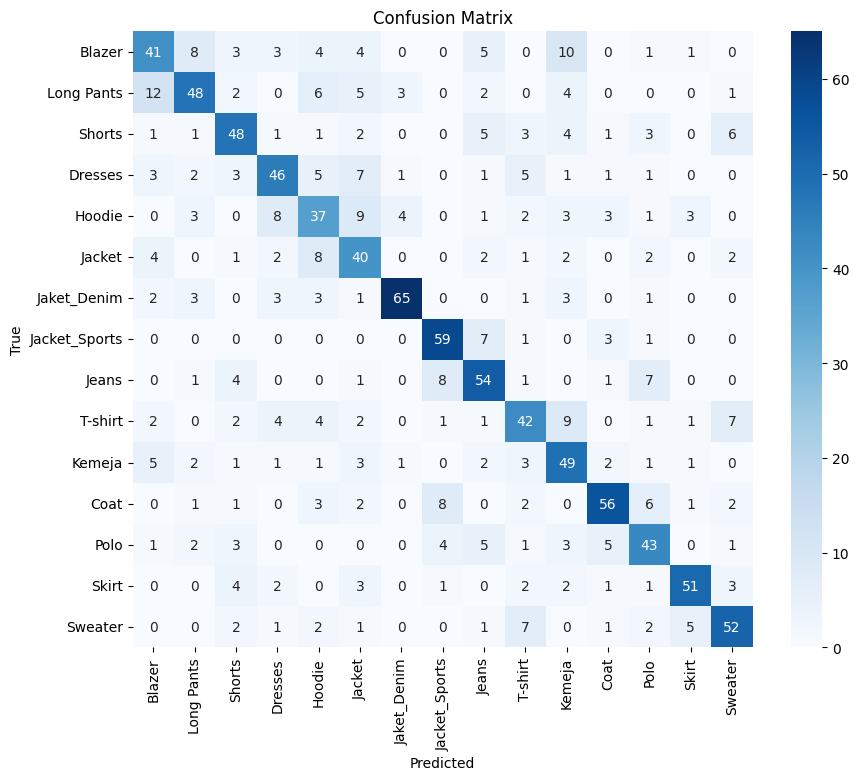

In [183]:
# Confusion Matrix
class_names = ['Blazer', 'Long Pants', 'Shorts', 'Dresses', 'Hoodie', 'Jacket', 'Jaket_Denim', 'Jacket_Sports', 'Jeans', 'T-shirt', 'Kemeja', 'Coat', 'Polo', 'Skirt', 'Sweater']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## **6. Улучшение модели**

In [ ]:
# Разморозка слоёв
for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.features[8].parameters():
    param.requires_grad = True

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# Создаем новый writer для улучшенного обучения
writer_finetune = SummaryWriter('runs/clothes_classification_finetune')

# Повторяем обучение с размороженными слоями
for epoch in range(10):  # Дообучение на 10 эпохах
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/10", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Преобразуем метки в one-hot encoded формат
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        # Применяем CutMix
        inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Преобразуем mixed метки обратно в индексы классов
        labels_indices = labels_mixed.argmax(dim=1)
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer_finetune.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer_finetune.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    print(f"Fine-tuning Epoch {epoch + 1}/10")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем writer для улучшенного обучения
writer_finetune.close()

# Сохранение финальной модели
torch.save(model.state_dict(), 'final_model_finetuned.pth')

Разморозим последние несколько слоёв EfficientNet-B0. Это позволит модели адаптироваться к вашим данным, не переобучаясь.

In [191]:
# Разморозка последних слоёв
for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.features[8].parameters():
    param.requires_grad = True

Используем меньший learning rate для дообучения.

In [192]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

Проведём дообучение на том же количестве эпох (20).

Используем раннюю остановку, чтобы избежать переобучения.

In [199]:
import torch.nn.functional as F

best_val_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0

for epoch in range(20):  # Дообучение на 20 эпохах
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/20", leave=False)
    for inputs, labels in train_loop:
        # Преобразуем метки в one-hot encoded формат
        labels_one_hot = F.one_hot(labels, num_classes=15).float()
        
        # Применяем CutMix
        inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Преобразуем mixed метки обратно в индексы классов
        labels_indices = labels_mixed.argmax(dim=1)
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Обновляем метрики
        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # labels уже в формате [batch_size]
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    print(f"Fine-tuning Epoch {epoch + 1}/20")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Сохранение финальной модели
torch.save(model.state_dict(), 'final_model_finetuned.pth')

Fine-tuning Epoch 1/20
Train Loss: 1.8526, Train Accuracy: 0.4339
Validation Loss: 1.2119, Validation Accuracy: 0.6003


Fine-tuning Epoch 2/20
Train Loss: 1.8453, Train Accuracy: 0.4248
Validation Loss: 1.1856, Validation Accuracy: 0.6238


KeyboardInterrupt: 